In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, 
    roc_auc_score,
    precision_score,
    classification_report,
    precision_recall_curve,
    confusion_matrix
)


import itertools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
df = pd.read_csv("churn_data.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
df['Exited'].value_counts()
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=4)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standartizer', StandardScaler()),
                # ('normalizer', MinMaxScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

Pipeline([('feats', feats)])

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
              

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(max_iter=1000, random_state = 40)),
])

gboost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, random_state = 49)),
])

In [9]:
logreg.fit(X_train, y_train)
gboost.fit(X_train, y_train)
logreg_preds = logreg.predict_proba(X_test)[:, 1]
gboost_preds = gboost.predict_proba(X_test)[:, 1]

In [10]:
def fscore(precision,recall):
    return (2 * precision * recall) / (precision + recall)

precision1, recall1, thresholds1 = precision_recall_curve(y_test, logreg_preds)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, gboost_preds)

# locate the index of the largest f score
fscore1 = fscore(precision1, recall1)
fscore2 = fscore(precision2, recall2)
ix1 = np.argmax(fscore1)
ix2 = np.argmax(fscore2)
print('logres\n','Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))
print('gboost\n','Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

logres
 Best Threshold=0.314970, F-Score=0.604, Precision=0.567, Recall=0.646
gboost
 Best Threshold=0.328166, F-Score=0.649, Precision=0.651, Recall=0.648


Тут явно выигрывает gboost по всем параметрам.

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1820  180]
 [ 175  325]]


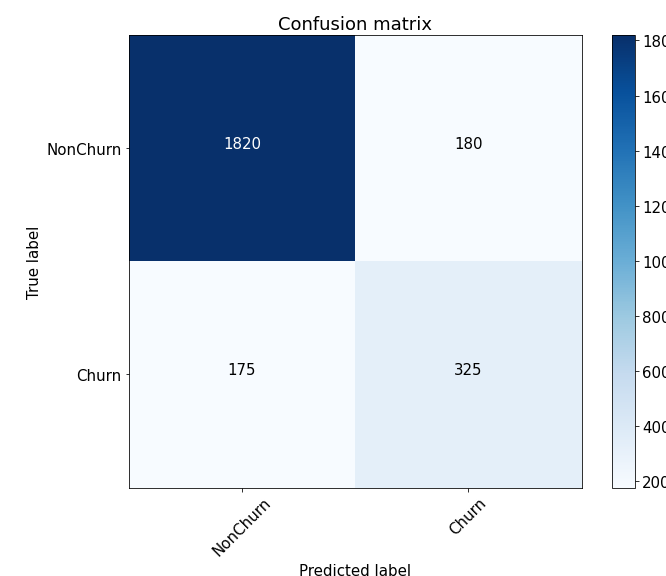

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gboost_preds>thresholds1[ix1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

- велью с удержания - 2 бакса, 
- за попытку вернуть - 1 бакс.

соответственно наше велью будет $EV = (TP*2-(TP+FP))/len(y\_test)=(TP-FP)/len(y\_test)= ($ она не относится напрямую ни к каким метрикам, только к комбинациям. напишем функцию

In [13]:
from sklearn.metrics import make_scorer

def best_expected_value(y_test, y_pred_proba, need_threshold=False):
    thresholds = np.linspace(0, 1, 500)
    best_threshold = 0
    best_ev = 0
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        if tp - fp > best_ev:
            best_ev = tp - fp
            best_threshold = threshold
    if need_threshold:
        return best_ev/len(y_test), best_threshold
    else:
        return best_ev/len(y_test)

ev_scorer = make_scorer(best_expected_value, needs_proba=True, greater_is_better=True)

In [14]:
%%time
ev, best_threshold = best_expected_value(y_test, gboost_preds, need_threshold=True)
ev, best_threshold

Wall time: 1.15 s


(0.0712, 0.4188376753507014)

Confusion matrix, without normalization
[[1905   95]
 [ 227  273]]


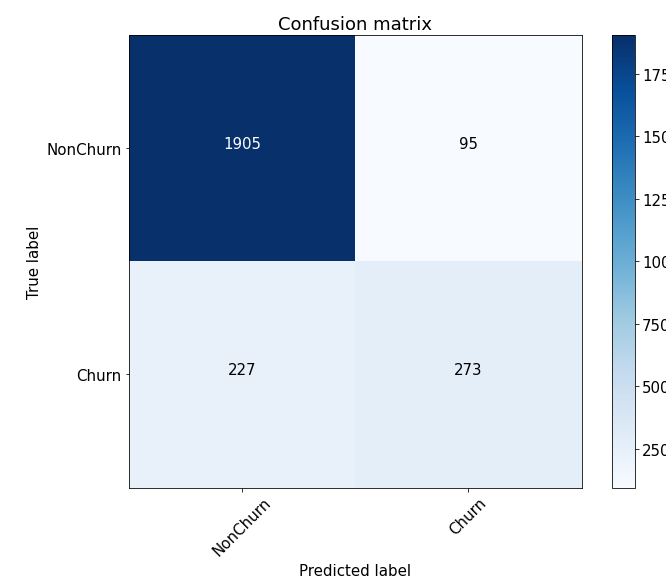

In [15]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gboost_preds>best_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Как мы видим мы получаем больше велью относительно лучшего f1 score

In [16]:
from sklearn.model_selection import GridSearchCV

learning_rate = np.linspace(0.02, 0.4, 10)
n_estimators = np.linspace(25, 300, 10, dtype='int32',)

params={'classifier__learning_rate':learning_rate,
        'classifier__n_estimators':n_estimators
        }

In [17]:
learning_rate, n_estimators

(array([0.02      , 0.06222222, 0.10444444, 0.14666667, 0.18888889,
        0.23111111, 0.27333333, 0.31555556, 0.35777778, 0.4       ]),
 array([ 25,  55,  86, 116, 147, 177, 208, 238, 269, 300]))

In [18]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Собираем GridSerch с нашим ev_scorer.

In [21]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=5,
                    refit=False,
                    n_jobs=4,
                    scoring=ev_scorer)
search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 8min 37s


{'classifier__learning_rate': 0.18888888888888888,
 'classifier__n_estimators': 55}

In [28]:
search.best_score_

0.06986666666666666

лучший скор такой так как делен на размер выборки. по сути мы получим:

In [35]:
search.best_score_ * 2500

174.66666666666666

Запускаем модель с лучшими параметрами.

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=7)
gboost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.18888888888888888, n_estimators=55, random_state = 42)),
])
gboost.fit(X_train, y_train)
gboost_preds = gboost.predict_proba(X_test)[:, 1]

ev, best_threshold = best_expected_value(y_test, gboost_preds, need_threshold=True)
ev, best_threshold, roc_auc_score(y_test, gboost_preds)

(0.0664, 0.5390781563126252, 0.8692624889151641)

через ev_scorer находим лучшей threshold

In [30]:
ev, best_threshold = best_expected_value(y_test, gboost_preds, need_threshold=True)
ev, best_threshold

(0.0664, 0.5390781563126252)

Это конфьюжн матрица для полученой нами модели и трешхолда.

Confusion matrix, without normalization
[[1932   58]
 [ 286  224]]


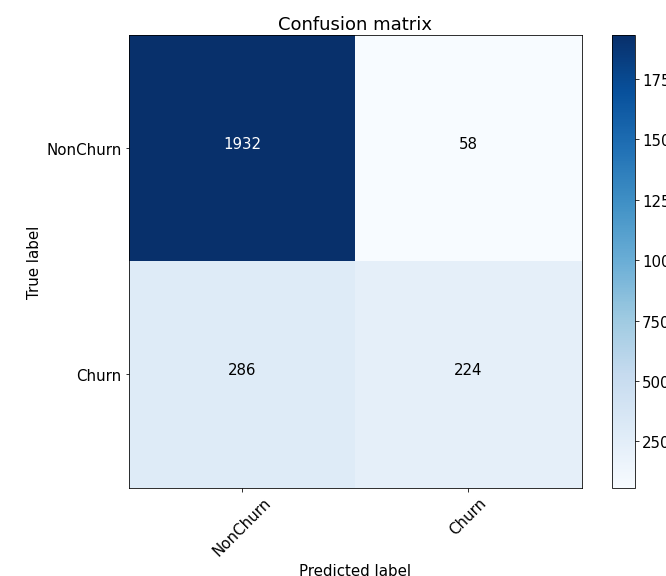

In [31]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gboost_preds>best_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [32]:

precision2, recall2, thresholds2 = precision_recall_curve(y_test, gboost_preds)
fscore2 = fscore(precision2, recall2)
ix2 = np.argmax(fscore2)
print('gboost\n','Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

gboost
 Best Threshold=0.220515, F-Score=0.629, Precision=0.542, Recall=0.751


а это для лучшего f1 score для нашей модели.

Confusion matrix, without normalization
[[1666  324]
 [ 128  382]]


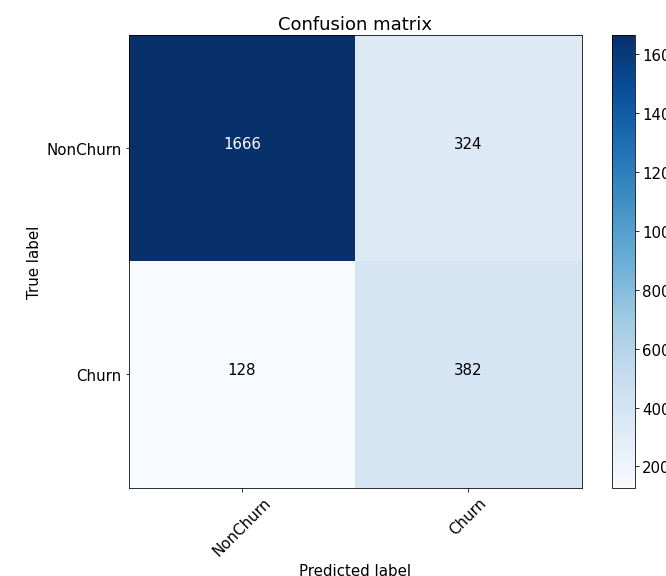

In [34]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gboost_preds>0.220515)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Опишу все что сделал.

Первое сдулал 2 пайплайна, logres и gboost.По обычным метрикам посмотрел какой из алгоритмов лучше - gboost справлялся на гораздо лучше.

Написал свой scorer который находит лучшее значение прибыли(она взята относительн размера выборки(иначе грид серч в зависимости размеравыборки считает ее по разному.)) threshold для модели при данных параметрах. чтобы получить обратно прибыль нужно умножить получившейся scorer на размер нашей выборки.

Сделал грид серч по этому скореру и получил параметры лучшей модели.

Как оказалось в конце наше первоначально резбиение влияет на полученный результат очень сильно. В зависимости от разбиения threshold имеет огромную дисперсию, это на самом деле замено и при поиске threshold для f1 score. 

Так что теоретически нужно включать в кросс валидацию параметр threshold и искать еще и с ним, но тогда для этого нужно несколько часов, которых у меня не осталось.

А так в общем в такой модели можно делать гридсерч прямо по размеру предпологаемой выборки.